# atomman.defect.Stroh.displacement(self, pos)

- - -

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Office of Data and Informatics, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-09-02

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## Introduction

The Stroh.displacement method computes the position-dependent displacements associated with a particular Stroh defect solution contained in an [atomman.defect.Stroh](atomman.defect.Stroh.ipynb) object. As the Stroh solution is a continuum elasticity solution the supplied positions can but do not have to correspond to atomic positions. The results of this method can be used to generate a dislocation monopole system.

More on the underlying theory can be found in [atomman.defect.Stroh.theory.pdf](atomman.defect.Stroh.theory.pdf).

Arguments:

- __pos__ -- a 3D vector position or a list/array of 3D vector positions.

__Note__: the Stroh displacement solution is undefined at y=0 for x<=0. The positions supplied to the function should be shifted to avoid these values.
        
The underlying code can be found in [atomman/defect/Stroh.py](https://github.com/usnistgov/atomman/blob/master/atomman/defect/Stroh.py).

## Demonstration

Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import atomman as am
import atomman.unitconvert as uc

### Solving for an fcc edge dislocation

Let's consider an fcc edge dislocation.
    
    Burgers-vector = a/2[ 1, 0,-1]
    slip plane =        [ 1, 1, 1]
    line-direction =    [ 1,-2, 1]
    
With how the solution is calculated, this means that the system should be oriented relative to the cubic crystal directions:

- x-axis = [ 1, 0,-1]
- y-axis = [ 1, 1, 1]
- z-axis = [ 1,-2, 1]

In [2]:
axes = np.array([[ 1, 0,-1],
                 [ 1, 1, 1],
                 [ 1,-2, 1]])

Lattice and elastic constants should correspond to the potential and temperature of interest and be converted into proper working units. The values below are for 2010--Winey-J-M--Al at 0 K. Proper conversion of units is handled by the [atomman.unitconvert module](atomman.unitconvert.ipynb).

In [3]:
alat = uc.set_in_units(4.0248, 'angstrom')
C11 =  uc.set_in_units(113.76, 'GPa')
C12 =  uc.set_in_units( 61.71, 'GPa')
C44 =  uc.set_in_units( 31.25, 'GPa')

Defining the elastic constants and Burgers vector relative to the cubic cell coordination system

In [4]:
c = am.ElasticConstants(C11=C11, C12=C12, C44=C44)
burgers = alat / 2 * np.array([1., 0., -1.])

Obtaining the proper a Stroh solution requires that the elastic constants matrix and Burgers vector be defined relative to the System of interest's Cartesian orientation. To handle this, you can either:

- Supply the elastic constants and Burgers vector relative to the Cartesian coordination system

- Supply the elastic constants and Burgers vector relative to reference coordination system, and give axes for the transformation.

For cubic systems, the second option allows for the elastic constants, Burgers vector, and axes vectors to be given relative to the cubic cell coordination system (which is what we have above).

In [5]:
#initializing a new Stroh object using the data
stroh = am.defect.Stroh(c, burgers, axes=axes)

### Find the displacement at a point

In [6]:
pos_test = uc.set_in_units(np.array([12.4, 13.5, -10.6]), 'angstrom')

disp = stroh.displacement(pos_test)
print "displacement =", uc.get_in_units(disp, 'angstrom'), 'angstrom'

displacement = [ 0.54802771 -0.14740711 -0.01333564] angstrom


### Creating a dislocation monopole system

The Stroh.displacement method can be used to insert a dislocation into an initially perfect bulk System.

Generate an fcc unit cell [System](atomman.System.ipynb).

In [7]:
box = am.Box(a=alat, b=alat, c=alat)
atoms = am.Atoms(natoms=4, prop={'atype':1, 'pos':[[0.0, 0.0, 0.0],
                                                   [0.5, 0.5, 0.0],
                                                   [0.0, 0.5, 0.5],
                                                   [0.5, 0.0, 0.5]]})
ucell = am.System(atoms=atoms, box=box, scale=True)

Create a new system by rotating the unit cell to the proper axes orientation with [rotate_cubic](atomman.rotate_cubic.ipynb).

In [8]:
system = am.rotate_cubic(ucell, axes)

Shift the atoms in the system. The y=0 slip plane should be positioned halfway between two atomic planes. Atoms can also be shifted such that x=0 is between two atomic planes as well.

In [9]:
shift = np.array([0.12500000000000, 0.50000000000000, 0.00000000000000])

new_pos = system.atoms_prop(key='pos', scale=True) + shift
system.atoms_prop(key='pos', value=new_pos, scale=True)

Increase the System's size with [System.supersize](atomman.System.supersize.ipynb).

In [10]:
system.supersize((-7, 7), (-6, 6), (0, 1))

Calculate the defect displacements for all atom positions.

In [11]:
disp = stroh.displacement(system.atoms_prop(key='pos'))

Apply the displacement to the system

In [12]:
system.atoms_prop(key='pos', value = system.atoms_prop(key='pos') + disp)

Change the [periodic boundary conditions](atomman.System.pbc.ipynb) in the x and y directions and [wrap](atomman.System.wrap.ipynb) the System

In [13]:
system.pbc = (False, False, True)
system.wrap()

Plot the new atomic positions to show the defect.

__WARNING!__ The Stroh displacements are associated with the ideal anisotropic elasticity solution. All atomic systems should be relaxed in order to obtain a true solution associated with the atomic position.

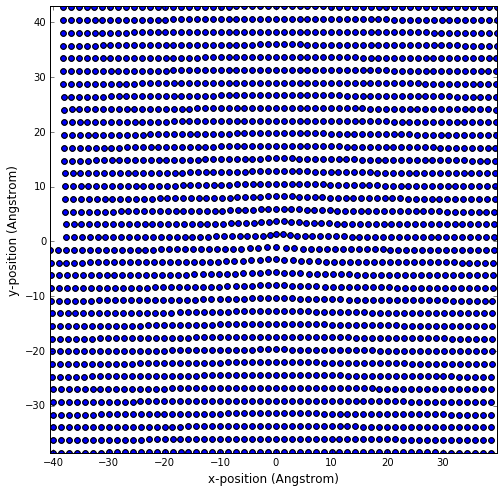

In [14]:
pos = system.atoms_prop(key='pos')
x = uc.get_in_units(pos[:,0], 'angstrom')
y = uc.get_in_units(pos[:,1], 'angstrom')
plt.figure(figsize=(8,8))
plt.scatter(x, y, s=30)

plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.xlabel('x-position (Angstrom)', fontsize='large')
plt.ylabel('y-position (Angstrom)', fontsize='large')

plt.show()

- - -
__Docs Navigation:__

Tutorial:

1. [Basics](../tutorial/1 Basics.ipynb)

2. [LAMMPS Functionality](../tutorial/2 LAMMPS Functionality.ipynb)

3. [Defect Generation and Evaluation](../tutorial/3 Defect Generation and Evaluation.ipynb)


Reference:

- [atomman](../reference/atomman.ipynb)

- [atomman.convert](../reference/atomman.convert.ipynb)

- [atomman.defect](../reference/atomman.defect.ipynb)

- [atomman.lammps](../reference/atomman.lammps.ipynb)

- [atomman.tools](../reference/atomman.tools.ipynb)

- [atomman.unitconvert](../reference/atomman.unitconvert.ipynb)